# Exploratory Analysis of metadata, data cleaning, and new feature creation

Purpose of this notebook:
1. Explore the many features of TED talks using the *full* metadata dataset. 
1. Create new features based on tags and ratings
1. Fix formats, remove incomplete or low-quality data
1. Write the new version of full metadata to csv file  


## Original Features Available

* **name:** The official name of the TED Talk. Includes the title and the speaker.
* **title:** The title of the talk
* **description:** A blurb of what the talk is about.
* **main_speaker:** The first named speaker of the talk.
* **speaker_occupation:** The occupation of the main speaker.
* **num_speaker:** The number of speakers in the talk.
* **duration:** The duration of the talk in seconds.
* **event:** The TED/TEDx event where the talk took place.
* **film_date:** The Unix timestamp of the filming.
* **published_date:** The Unix timestamp for the publication of the talk on TED.com
* **comments:** The number of first level comments made on the talk.
* **tags:** The themes associated with the talk.
* **languages:** The number of languages in which the talk is available.
* **ratings:** A stringified dictionary of the various ratings given to the talk (inspiring, fascinating, jaw dropping, etc.)
* **related_talks:** A list of dictionaries of recommended talks to watch next.
* **url:** The URL of the talk.
* **views:** The number of views on the talk.

In [272]:
%matplotlib inline
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import ast
from math import log
from operator import itemgetter
from collections import OrderedDict
import aux_code.functions as mfc
import gender_guesser.detector as gender

from IPython.core.display import display, HTML
pd.set_option('display.max_colwidth', -1)  # to fix problem with html for long urls not showing up

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

pd.set_option('display.max_rows', 20)

In [273]:
# Read metadata from ted_main
df = pd.read_csv('data/ted-talks/ted_main.csv')
print(*df.columns, sep=', ')
df.shape

comments, description, duration, event, film_date, languages, main_speaker, name, num_speaker, published_date, ratings, related_talks, speaker_occupation, tags, title, url, views


(2550, 17)

In [274]:
# name index column
df.index.name = 'Id'

## HTML links based on urls

In [275]:
# tidy up urls by removing trailing '\n'
df['url'] = df['url'].apply(lambda x: x.replace('\n',''))

In [276]:
# create new column 'link' using html to display url as a link so that I can inspect talks
# dfHtmlObj = df.to_html() creates an html object, (no longer a df) 
# that will look like a df if displayed with display(HTML(dfHtmlObj))

df['link'] = df['url'].apply(lambda x: '<a href="'+x+'" target="_blank">link</a>')

# Example of how to display
dftemp = df[['title','duration','event','link']].head(5)
display(HTML(dftemp.to_html(escape=False)))  # Note: requires pd.set_option('display.max_colwidth', -1)

,title,duration,event,link
Id,,,,
0,Do schools kill creativity?,1164,TED2006,link
1,Averting the climate crisis,977,TED2006,link
2,Simplicity sells,1286,TED2006,link
3,Greening the ghetto,1116,TED2006,link
4,The best stats you've ever seen,1190,TED2006,link


## Most Viewed talks

What are the **most viewed talks**?

Insights: 
1. Many of these talks are by celebrity speakers
2. These have between 16 and 47 Million views

In [277]:
# Average number of views of top 10:
most_viewed = df[['title', 'main_speaker', 'views', 'film_date']].sort_values('views', ascending=False)[:15]
most_viewed[0:10]

,title,main_speaker,views,film_date
Id,,,,
0,Do schools kill creativity?,Ken Robinson,47227110,1140825600
1346,Your body language may shape who you are,Amy Cuddy,43155405,1340668800
677,How great leaders inspire action,Simon Sinek,34309432,1253145600
837,The power of vulnerability,Brené Brown,31168150,1275782400
452,10 things you didn't know about orgasm,Mary Roach,22270883,1233878400
1776,How to speak so that people want to listen,Julian Treasure,21594632,1370822400
201,My stroke of insight,Jill Bolte Taylor,21190883,1204070400
5,Why we do what we do,Tony Robbins,20685401,1138838400
2114,This is what happens when you reply to spam email,James Veitch,20475972,1449532800


In [278]:
 # average of **1.6** million views per video
df['views'].describe()

count    2.550000e+03
mean     1.698297e+06
std      2.498479e+06
min      5.044300e+04
25%      7.557928e+05
50%      1.124524e+06
75%      1.700760e+06
max      4.722711e+07
Name: views, dtype: float64

1,698,297.0 average views


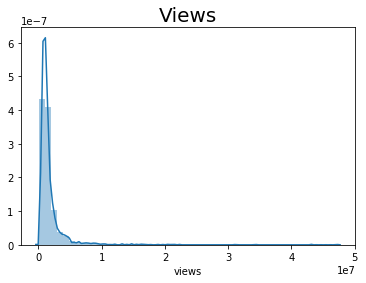

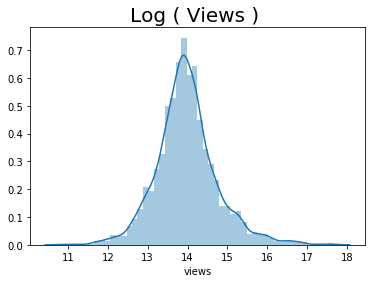

In [279]:
# pretty print large numbers
print("{:,}".format(round(df['views'].mean(),0)), 'average views' )

plt.title('Views', size=20)
sns.distplot(df['views'])

# log of views  (# related to the doubling rate)
plt.show()
plt.title('Log ( Views ) ', size=20)
sns.distplot(np.log(df['views']));

###### TED vs TEDx

What's the distribution of TED vs TEDx talks?

- To answer this question, I have to create a column distinguishing the two. Because the two types are different, for some analyses, I might want to restrict to just one kind of event or at least to look at them separately.

Insights:
1. 969 of the 2,550 talks are from annual TED events (as opposed to TEDx and other events)


In [280]:
# See how many of the talks are from annual TED events
# All ted yearly talks have event names that start with ted2

df['annualTED'] = [1 if event.startswith('TED2') else 0 for event in df['event']]
sum(df['annualTED'])

969

In [281]:
df.groupby('annualTED')['views','comments','languages'].mean()

,views,comments,languages
annualTED,,,
0,1.564294e+06,179.324478,26.518659
1,1.916935e+06,211.529412,28.643963


In [282]:
# Which events had the most talks?
df.groupby('event').aggregate('count')['title'].sort_values(ascending=False)[:15]

event
TED2014           84
TED2009           83
TED2013           77
TED2016           77
TED2015           75
TED2011           70
TEDGlobal 2012    70
TED2010           68
TED2007           68
TEDGlobal 2011    68
TED2017           67
TEDGlobal 2013    66
TED2012           65
TEDGlobal 2009    65
TED2008           57
Name: title, dtype: int64

## Published year
- talks in the metadata set range from 2006 - 2017
- Since film_date and published_date are redundant, I keep film_date and change published_date to published_year.
- Just because a talk has been out for longer, doesn't mean it has the most views. 
    - Hypothesis: As TED.com gains a bigger audience, and recent talks are more prominent on the website, recent talks get viewed much more than older talks.

In [283]:
# Use Datetime to make dates understandable and more manageable
# Create a column 'year' for just the year published, as integer
print(type(df.iloc[0]['film_date']))

<class 'numpy.int64'>


In [284]:
df['film_date'] = df['film_date'].apply(lambda x: datetime.datetime.fromtimestamp( int(x)).strftime('%d-%m-%Y'))
df['published_date'] = df['published_date'].apply(lambda x: datetime.datetime.fromtimestamp( int(x)).strftime('%d-%m-%Y'))

# Create year column
df['film_year'] = df['film_date'].apply(lambda x: x.split('-')[2])
df['published_year'] = df['published_date'].apply(lambda x: x.split('-')[2])
df.film_year=df.film_year.astype(int)
df.published_year=df.published_year.astype(int)

In [285]:
df.published_year.describe()

count    2550.000000
mean     2012.093333
std      3.011667   
min      2006.000000
25%      2010.000000
50%      2012.000000
75%      2015.000000
max      2017.000000
Name: published_year, dtype: float64

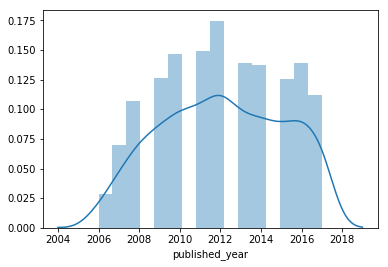

In [286]:
ax = sns.distplot(df['published_year'])

## Comments

What makes a talk get many comments? 

Insights: 
1. Talks with most comments seem to be those with controversial topics
1. Comments vs year are somewhat positively correlated, with a pearson correlation of 0.53. 

In [287]:
df.comments.describe()

count    2550.000000
mean     191.562353 
std      282.315223 
min      2.000000   
25%      63.000000  
50%      118.000000 
75%      221.750000 
max      6404.000000
Name: comments, dtype: float64

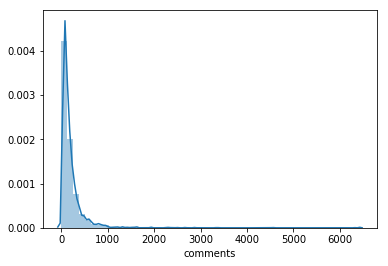

In [288]:
ax = sns.distplot(df['comments'])

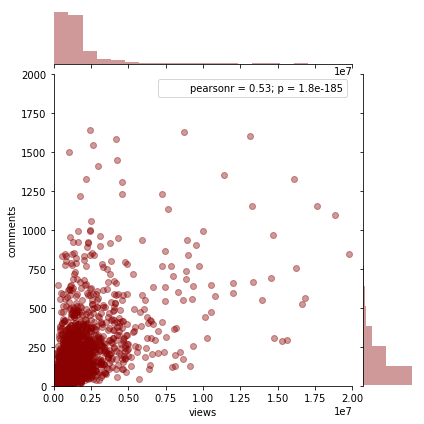

In [289]:
# Plot comments vs year are somewhat positively correlated
# Notice the pearson correlation of 0.53
#  p-value of 1.8e(-185) not informative since the distributions are far from normal

# scatter plot of views vs comments
ax = sns.jointplot(x='views', y='comments', data=df, ylim=(0, 2000), xlim=(0,2e7), color='darkred', alpha=.4)


## Languages

Number of languages in which each talk is translated

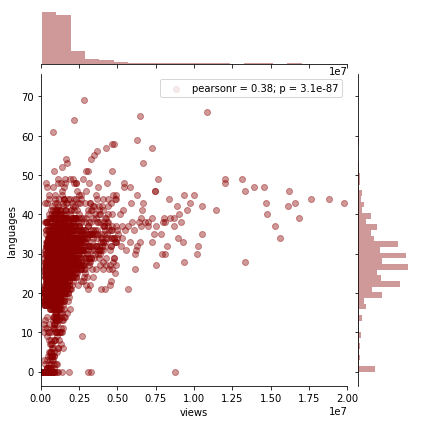

In [290]:
# Are views and number of languages correlated? 

# Talks are available in 0 to 70 different languages, but most fall between 20 and 40
# There is some moderate correlation: some of the most viewed are some of the most translated.

sns.jointplot(x='views', y='languages', data=df, xlim = (0,2e7), color='darkred', alpha=.4)

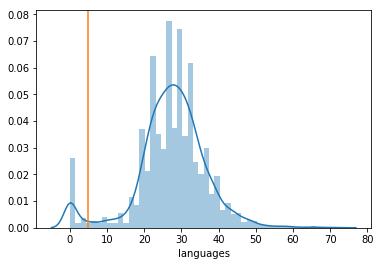

In [291]:
# See distribution of languages
ax = sns.distplot(df['languages'])
# plot a vertical line
xmin = 5; xmax = np.nan; mfc.axvlines([xmin, np.nan])

In [292]:
# see titles of talks translated to 0 languages
# Observation: many of these are musical performances 

df.loc[df['languages']<1, 'title']

Id
58      A dance of "Symbiosis"                   
115     A string quartet plays "Blue Room"       
135     "Woza"                                   
209     "M'Bifo"                                 
237     "Kounandi"                               
249     A performance with breath, music, passion
399     Piano jazz that rocks                    
446     Chaos and harmony on piano               
474     An electrifying organ performance        
512     Hypnotic South Asian improv music        
                      ...                        
1229    Beethoven the businessman                
1237    The sea we've hardly seen                
1301    When a reporter becomes the story        
1307    Is life really that complex?             
1341    An animated tour of the invisible        
1427    I think we all need a pep talk           
1467    The technology of touch                  
1486    How much does a video weigh?             
2407    "Turceasca"                            

## Duration

The average duration of each talk is about 17 minutes. 

In [293]:
#Convert Duration to minutes
df['duration'] = round(df['duration']/60, 1)
df.duration.describe()

count    2550.000000
mean     13.775137  
std      6.233029   
min      2.200000   
25%      9.600000   
50%      14.100000  
75%      17.400000  
max      87.600000  
Name: duration, dtype: float64

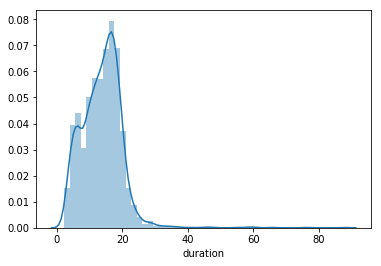

In [294]:
# Distribution of talk durations
ax = sns.distplot(df['duration'])

In [295]:
# display links to talks that lasted over 30 minutes to inspect them
dftemp = df.loc[df['duration']>=30, ['title', 'duration', 'event','link']].sort_values('duration', ascending=False) 
dftemp = dftemp[0:5]
display(HTML(dftemp.to_html(escape=False)))

,title,duration,event,link
Id,,,,
640,"Parrots, the universe and everything",87.6,University of California,link
588,Really achieving your childhood dreams,76.4,Carnegie Mellon University,link
629,Physics is fun to imagine,65.9,BBC TV,link
2387,Nationalism vs. globalism: the new political divide,60.1,TED Dialogues,link
594,Stories of Haiti,59.6,University of California,link


# More new features

## Number of speakers

In [296]:
df.groupby('num_speaker')['title'].aggregate('count')

num_speaker
1    2492
2    49  
3    5   
4    3   
5    1   
Name: title, dtype: int64

## Number of appearances
Count how many talks by each speaker are in this dataset. 

The counts may be underestimated, because many talks don't get published on the website and onto this dataset, especially older and less popular talks. 

In [297]:
# Here are names of speakers with the most online TED appearances (this only accounts for online ted talks in this dataset)

talksDf = df.groupby('main_speaker').count().reset_index()[['main_speaker', 'name']].sort_values('name',ascending = False)     
talksDf[0:9]

,main_speaker,name
770,Hans Rosling,9
1066,Juan Enriquez,7
1693,Rives,6
1278,Marco Tempest,6
397,Clay Shirky,5
1487,Nicholas Negroponte,5
1075,Julian Treasure,5
424,Dan Ariely,5
850,Jacqueline Novogratz,5


In [298]:
df['num_speaker_talks'] = 1
for ix, row in talksDf[talksDf['name'] >= 2].iterrows() :
    df.loc[df['main_speaker']==row[0],'num_speaker_talks'] = row[1]

## Topics

Here, I extract topic labels from a list of tags that is given for each video. These tags were assigned by TED's tagging system.

Insights: 
1. Most popular topics are Science and Technology. Other top ones are Entertainment, Technology, Globali Issues, Psychology, and Health.

In [299]:
# Here's an example of the tags given.
# We can extract information about topic, funding (e.g. MacArthur grant)
# 
df['tags'] = df['tags'].apply(lambda x: ast.literal_eval(x))
df['tags'][:5]

Id
0    [children, creativity, culture, dance, education, parenting, teaching]                                              
1    [alternative energy, cars, climate change, culture, environment, global issues, science, sustainability, technology]
2    [computers, entertainment, interface design, media, music, performance, simplicity, software, technology]           
3    [MacArthur grant, activism, business, cities, environment, green, inequality, politics, pollution]                  
4    [Africa, Asia, Google, demo, economics, global development, global issues, health, math, statistics, visualizations]
Name: tags, dtype: object

In [300]:
# Stack (series) of all the tags for every talk. Average 7 tags per talk
s = df.apply(lambda x: pd.Series(x['tags']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'topic'
# Adding 'topic' and removing 'tags'  (add column for number of tags?)
print(len(s))
list(s).count('education')
s.tail(2)

19154


Id
2549    software      
2549    urban planning
Name: topic, dtype: object

In [301]:
# Make a df containing a row for each tag+index combination
topicDf = df.join(s)
print(topicDf.shape)
topicDf[['title','topic']].head(2)

(19154, 23)


,title,topic
Id,,
0,Do schools kill creativity?,children
0,Do schools kill creativity?,creativity


In [302]:
# df of number of talks for each topic, sorted in decreasing order
topTopics = pd.DataFrame(topicDf['topic'].value_counts()).reset_index()
topTopics.columns = ['topic', 'talks']
topTopics.head(15)
topTopicsList = list(topTopics.topic[:11])
topTopicsList.remove('TEDx')

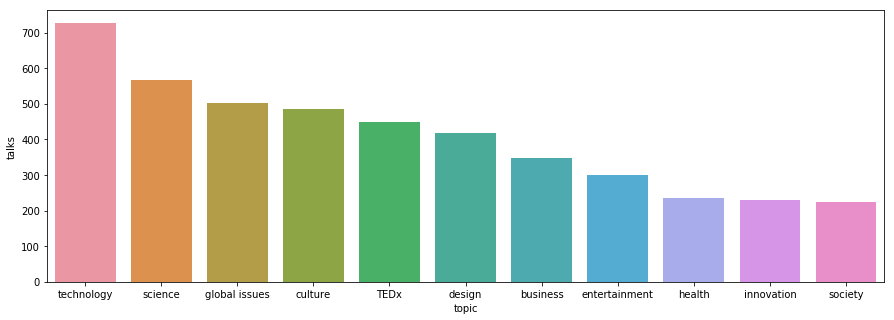

In [303]:
plt.figure(figsize=(15,5))
sns.barplot(x='topic', y='talks', data=topTopics.head(11))
plt.show()

(0, 4000000.0)

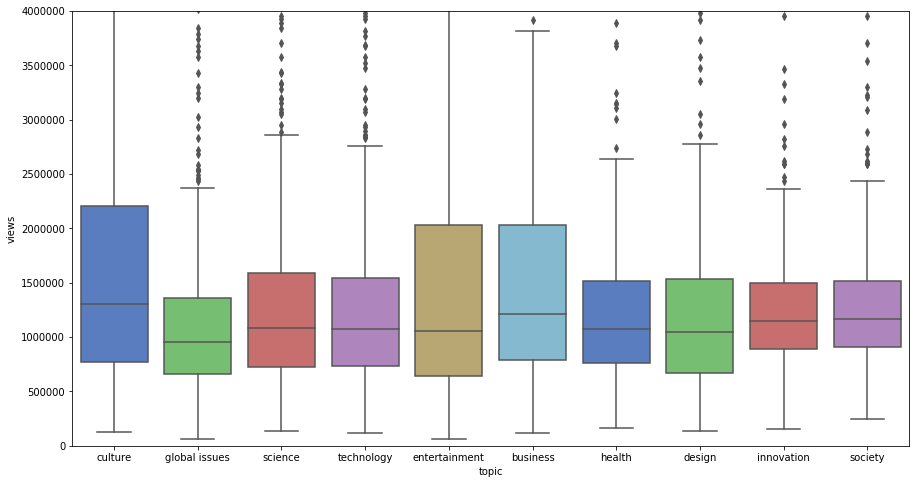

In [304]:
topTopicTalks = topicDf[topicDf['topic'].isin(topTopicsList)]
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(15, 8))
sns.boxplot(x='topic', y='views', data=topTopicTalks, palette="muted", ax =ax)
ax.set_ylim([0, 0.4e7])

In [305]:
# Create columns for the top 10 topics
for topicCol in topTopicsList:
    df[topicCol] = [1 if topicCol in tagL else 0 for tagL in df['tags']  ]


In [306]:
df.columns[-18:]

Index(['title', 'url', 'views', 'link', 'annualTED', 'film_year',
       'published_year', 'num_speaker_talks', 'technology', 'science',
       'global issues', 'culture', 'design', 'business', 'entertainment',
       'health', 'innovation', 'society'],
      dtype='object')

## Rating counts

Viewers on TED.com can give up to 3 different ratings to each talk, from a first list of 14 ratings and an option to submit a custom rating. If a viewer only selects one rating, then it counts three times. 

Rating counts are very low compared to numbers of views, showing that very few viewers are compelled to rate talks. 

Talks get drastically different amount of exposure, such as by being posted on the home page or appearing more in recommended talks. One sign of this is how much newer talks have more views than older talks. 

For these two reasons, it may be misleading to use ratings as a quantitative measure. 

Perhaps they can only be relied upon as qualitative indicators. We can expect that when people are compelled to rate a talk, they rate it in a way that truly reflects how they feel about the talk.

For a given talk, if a rating (say 'Funny') has 20% more counts than another rating (say 'Longwinded'), and the total number of ratings is large, then perhaps we can safely assume that the talk is more 'Funny' than 'Longwinded.'


In [307]:
# make each cell a list, rather than a string of a list
df['ratings'] = df['ratings'].apply(lambda x: eval(str(x)))
df['ratings'][0]

[{'count': 19645, 'id': 7, 'name': 'Funny'},
 {'count': 4573, 'id': 1, 'name': 'Beautiful'},
 {'count': 6073, 'id': 9, 'name': 'Ingenious'},
 {'count': 3253, 'id': 3, 'name': 'Courageous'},
 {'count': 387, 'id': 11, 'name': 'Longwinded'},
 {'count': 242, 'id': 2, 'name': 'Confusing'},
 {'count': 7346, 'id': 8, 'name': 'Informative'},
 {'count': 10581, 'id': 22, 'name': 'Fascinating'},
 {'count': 300, 'id': 21, 'name': 'Unconvincing'},
 {'count': 10704, 'id': 24, 'name': 'Persuasive'},
 {'count': 4439, 'id': 23, 'name': 'Jaw-dropping'},
 {'count': 1174, 'id': 25, 'name': 'OK'},
 {'count': 209, 'id': 26, 'name': 'Obnoxious'},
 {'count': 24924, 'id': 10, 'name': 'Inspiring'}]

In [308]:
ratingsL = list(set([item for item in df['ratings'].apply(lambda x: x[0]['name'])] ))  
print(len(ratingsL))
print(*ratingsL, sep=',')

14
Fascinating,Courageous,Longwinded,Obnoxious,Jaw-dropping,Inspiring,OK,Beautiful,Funny,Unconvincing,Ingenious,Informative,Confusing,Persuasive


In [309]:
# Create columns for the various ratings  
# dfR stands for  df ratings

dfR = pd.DataFrame( columns=['title']+ratingsL)
dfR[['title']]=df[['title']]
dfR.shape

(2550, 15)

In [310]:
for ix, val in enumerate(df['ratings']): #each val is a row of dfR
    dfR.iloc[ix]['title'] = df.iloc[ix]['title']
    for item in val:  #each item is a dictionary for a single adjective
        category = item['name']
        dfR.iloc[ix][category] = np.int64(item['count'])

In [311]:
dfR.head(3)

,title,Fascinating,Courageous,Longwinded,Obnoxious,Jaw-dropping,Inspiring,OK,Beautiful,Funny,Unconvincing,Ingenious,Informative,Confusing,Persuasive
Id,,,,,,,,,,,,,,,
0,Do schools kill creativity?,10581,3253,387,209,4439,24924,1174,4573,19645,300,6073,7346,242,10704
1,Averting the climate crisis,132,139,113,131,116,413,203,58,544,258,56,443,62,268
2,Simplicity sells,166,45,78,142,54,230,146,60,964,104,183,395,27,230


In [312]:
# Merge df and dfR by title

df=pd.merge(df, dfR, on='title') ; df.head(2)
df.columns

Index(['comments', 'description', 'duration', 'event', 'film_date',
       'languages', 'main_speaker', 'name', 'num_speaker', 'published_date',
       'ratings', 'related_talks', 'speaker_occupation', 'tags', 'title',
       'url', 'views', 'link', 'annualTED', 'film_year', 'published_year',
       'num_speaker_talks', 'technology', 'science', 'global issues',
       'culture', 'design', 'business', 'entertainment', 'health',
       'innovation', 'society', 'Fascinating', 'Courageous', 'Longwinded',
       'Obnoxious', 'Jaw-dropping', 'Inspiring', 'OK', 'Beautiful', 'Funny',
       'Unconvincing', 'Ingenious', 'Informative', 'Confusing', 'Persuasive'],
      dtype='object')

In [313]:
print(len(df['ratings'][3]))
def sort_ratings(ratingsList):
    #the first ratingsList is df['ratings'][0]
    newdict = {}
    for item in ratingsList:
        newdict[item['name']] = item['count']
    newdict = OrderedDict(sorted(newdict.items(), key = lambda x: x[1], reverse=True)) 
    return newdict
df['ratings'][0][0:3]

14


[{'count': 19645, 'id': 7, 'name': 'Funny'},
 {'count': 4573, 'id': 1, 'name': 'Beautiful'},
 {'count': 6073, 'id': 9, 'name': 'Ingenious'}]

In [314]:
# Change ratings to give category sorted by descending count
# Replace df['ratings'] with df['ratings_new]
df['ratings'] = df['ratings'].apply(lambda x: sort_ratings(x))
df['ratings'][0]

OrderedDict([('Inspiring', 24924),
             ('Funny', 19645),
             ('Persuasive', 10704),
             ('Fascinating', 10581),
             ('Informative', 7346),
             ('Ingenious', 6073),
             ('Beautiful', 4573),
             ('Jaw-dropping', 4439),
             ('Courageous', 3253),
             ('OK', 1174),
             ('Longwinded', 387),
             ('Unconvincing', 300),
             ('Confusing', 242),
             ('Obnoxious', 209)])

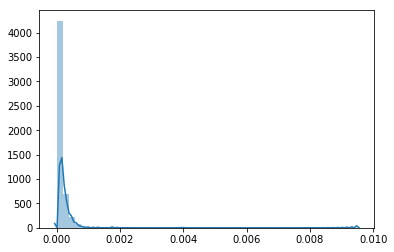

In [327]:
for col in ratingsL:
    df[col] = np.int64(df[col])
sns.distplot(df['Beautiful']/df['views'])
# most talks have count = 0 for 'Beautiful'

### See how ratings correlate with other factors

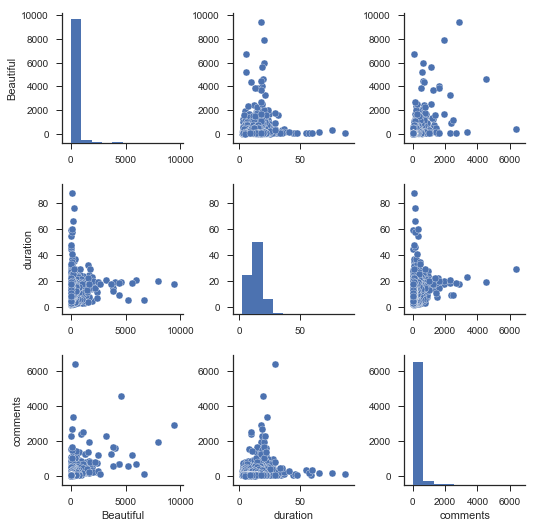

In [328]:
# import seaborn as sns
sns.set(style="ticks")

sns.pairplot(df[['Beautiful', 'duration','comments']])
# Hardly any correlation between these three
# comments distribution isn't gaussian

# New NLP features

We use the dataset with the transcripts to gain some insights into the conent of each talk

## Words per minute
- estimate the rate of speaking from the total duration of each talk and total number of words in its transcript.

- the transcripts dataset have the talk's url, so that can be used to match the transcript with the rest of the metadata.

In [343]:
df2 = pd.read_csv('data/ted-talks/transcripts.csv')
print(df2.shape, df2.columns)
df2['url'] = df2['url'].apply(lambda x: x.replace('\n', ''))
print(df2.loc[0,'transcript'][0:200],'\nLength:', len(df2.loc[0,'transcript']))

(2467, 2) Index(['transcript', 'url'], dtype='object')
Good morning. How are you?(Laughter)It's been great, hasn't it? I've been blown away by the whole thing. In fact, I'm leaving.(Laughter)There have been three themes running through the conference whic 
Length: 17409


In [344]:
dftext = pd.merge(left=df,right=df2, how='left', left_on='url', right_on='url')
dftext = dftext[['url','transcript','duration']]
print(dftext.shape)
print(len(dftext.loc[0,'transcript']))

(2559, 3)
17409


In [345]:
dftext['transcript'] = dftext['transcript'].fillna('')
dftext['wc'] = dftext['transcript'].apply(lambda x: len(x.split()))
#dftext['title'] = df['title']

In [346]:
dftext['wc'].describe()

count    2559.000000
mean     1971.804220
std      1009.465375
min      0.000000   
25%      1233.000000
50%      1983.000000
75%      2683.000000
max      9044.000000
Name: wc, dtype: float64

In [347]:
dftext['words_per_min'] = round(dftext['wc']/dftext['duration'], 0)
dftext['words_per_min'].describe()

count    2559.000000
mean     142.153576 
std      39.599099  
min      0.000000   
25%      131.000000 
50%      149.000000 
75%      165.000000 
max      247.000000 
Name: words_per_min, dtype: float64

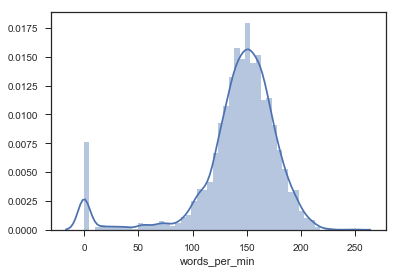

In [348]:
sns.distplot(dftext['words_per_min'])

# The talks with wpm=0 may just be missing a transcript.

In [349]:
df = pd.merge(left=df,right=dftext[['url','words_per_min']], how='inner', left_on='url', right_on='url')
print(df.shape)
df[['title','words_per_min']].head(3)

(2571, 48)


,title,words_per_min
0,Do schools kill creativity?,158.0
1,Averting the climate crisis,128.0
2,Simplicity sells,152.0


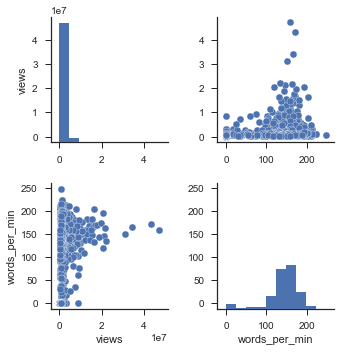

In [350]:
dataset = df[['views', 'words_per_min']]

#f, ax = plt.subplots(figsize=(8, 8))
#corr = dataset.corr()
#sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap="PiYG", center = 0,  square=True, ax=ax)
sns.pairplot(dataset)

## Gender from first name

I add a label from 0 - 1 produced using gender_guesser based on the first name of the main speaker. 
It is trained on a corpus of 40,000 names from all over the world. [gender_guesser](https://pypi.python.org/pypi/gender-guesser/)

'andy' is the gender_guesser label for androgenous names.

In [354]:
# Adding first_name, gender, and gender_class columns


df['first_name'] = df['main_speaker'].apply(lambda x : x.split(' ')[0])

genderList = [0]*len(df['first_name'])
detector = gender.Detector()

for ix, row in df.iterrows():
    #d.get_gender(u"Bob")
    name = row['first_name']
    thisGender = detector.get_gender(name)
    genderList[ix]=thisGender

df['gender_name'] = genderList
print(df[['first_name','gender_name']].groupby('gender_name').count())
df[['first_name','gender_name']].head(5)

               first_name
gender_name              
andy           33        
female         642       
male           1448      
mostly_female  55        
mostly_male    94        
unknown        299       


,first_name,gender_name
0,Ken,male
1,Al,male
2,David,male
3,Majora,unknown
4,Hans,male


In [355]:
df.loc[df['gender_name']=='andy' ,['first_name','gender_name']][0:5]

,first_name,gender_name
21,Ze,andy
32,Aubrey,andy
323,Jackie,andy
474,Qi,andy
790,Ze,andy


In [356]:
# The gender labels/values are indicative of the confidence. 
# 1 and 0 are the only high-confidence labels.
# The assumption here is that name is truly indicative of gender.
genderSubs = {'female': 1, 'mostly_female':0.75, 'mostly_male':0.25, 'male':0, 'andy':np.nan, 'unknown':np.nan}   
df['gender_name_class'] = list(map(genderSubs.get, df['gender_name']  ))
df[['gender_name','gender_name_class']][:7]

,gender_name,gender_name_class
0,male,0.0
1,male,0.0
2,male,0.0
3,unknown,NaN
4,male,0.0
5,male,0.0
6,female,1.0


# Summary

Original metadata features:

* **name:** The official name of the TED Talk. Includes the title and the speaker.
* **title:** The title of the talk
* **description:** A blurb of what the talk is about.
* **main_speaker:** The first named speaker of the talk.
* **speaker_occupation:** The occupation of the main speaker.
* **num_speaker:** The number of speakers in the talk.
* **duration:** The duration of the talk in seconds
    - changed to minutes
* **event:** The TED/TEDx event where the talk took place.
* **film_date:** The Unix timestamp of the filming.
	- changed to datetime format
* **published_date:** The Unix timestamp for the publication of the talk on TED.com
	- changed to datetime format
* **comments:** The number of first level comments made on the talk.
* **tags:** The themes associated with the talk.
* **languages:** The number of languages in which the talk is available.
* **ratings:** A stringified dictionary of the various ratings given to the talk (inspiring, fascinating, jaw dropping, etc.)
	- changed to an ordered  dictionary sorted by descending frequency
* **related_talks:** A list of dictionaries of recommended talks to watch next.
* **url:** The URL of the talk.
* **views:** The number of views on the talk.

Enhanced metadata:

* **link:** (html tag to display url as a link that gets opened in a new tab)  
* **annualTED:** 1 if event is an annual TED event rather than a TEDx event.  
* **film_year**  
* **published_year**  
* **num_speaker_talks**  

Topics: 
* **technology, 'science','global issues', 'culture', 'design', 'business', 'entertainment','health', 'innovation', 'society'**

Ratings: 
* **Fascinating, Courageous, Longwinded, Obnoxious, Jaw-dropping, Inspiring, OK, Beautiful, Funny, Unconvincing, Ingenious, Informative, Confusing, Persuasive**
    
From gender_guesser:
* gender_name: 
* gender_name_class : 0 for "mostly male" and 1 for "mostly female"


In [357]:
print(df.columns)
df.shape

Index(['comments', 'description', 'duration', 'event', 'film_date',
       'languages', 'main_speaker', 'name', 'num_speaker', 'published_date',
       'ratings', 'related_talks', 'speaker_occupation', 'tags', 'title',
       'url', 'views', 'link', 'annualTED', 'film_year', 'published_year',
       'num_speaker_talks', 'technology', 'science', 'global issues',
       'culture', 'design', 'business', 'entertainment', 'health',
       'innovation', 'society', 'Fascinating', 'Courageous', 'Longwinded',
       'Obnoxious', 'Jaw-dropping', 'Inspiring', 'OK', 'Beautiful', 'Funny',
       'Unconvincing', 'Ingenious', 'Informative', 'Confusing', 'Persuasive',
       'wpm', 'words_per_min', 'first_name', 'gender_name',
       'gender_name_class'],
      dtype='object')


(2571, 51)

# Write to file

In [358]:
df.to_csv('data/meta_plus.csv')